## Pós-processamento de Dados dos Processos Judiciais Envolvendo MEI

Este notebook realiza uma série de etapas para tratamento, enriquecimento e visualização de dados judiciais relacionados a Microempreendedores Individuais (MEIs). As ações são voltadas à estruturação de informações extraídas de campos textuais em JSON e posterior análise jurimétrica.

### Etapas Realizadas:

1. **Leitura e parsing do campo `response` em formato JSON:**
   - O campo `response` contém um JSON com as seguintes chaves:
     - `descricao_caso`
     - `questoes_em_discussao`
     - `solucoes_propostas`
     - `decisao`
     - `tese`
     - `envolve_mei`
     - `mei_do_processo`
   - O script tenta decodificar o JSON e preencher as colunas correspondentes na tabela `processos`.
   - Se o JSON estiver malformado ou ausente, o campo `json_bem_formado` é preenchido com `0`, caso contrário com `1`.

2. **Classificação do Ramo da Justiça:**
   - A partir do campo `tribunal` (ex: `TRT-4`, `TJ-DF`), o script extrai a sigla principal e classifica o processo em um dos seguintes ramos:
     - `Justiça do Trabalho` (TRT, TST)
     - `Justiça Federal` (TRF, STF, STJ)
     - `Justiça Estadual` (TJ)
     - `Justiça Eleitoral` (TRE, TSE, TCE)
     - `Contas da União` (TCU)
     - Ou mantém o valor original, se não corresponder a nenhum caso anterior
   - O resultado é salvo na coluna `ramo_justica`.

3. **Geração de Gráfico de Barras:**
   - Após o enriquecimento dos dados, o script realiza uma consulta filtrando apenas os registros com `envolve_mei = '1'`.
   - Os resultados são agrupados por `ramo_justica` e visualizados em um gráfico de barras com `matplotlib`.

4. **Geração dos embeddings:**
   - Geração do embeddings da descricao_caso concatenada a questoes_em_discussao com o BERTimbau e armazenamento no banco


5. **Confirmação do Papel do MEI no processo:**
   - Em torno de 2400 processos não vieram como nome correto do Papel do Mei (Autor, Réu, ou Autor e Réu), esses procxessos foram consultadso novamente no LLM solicitando confirmação do papel correto do MEI.

In [11]:
import psycopg2
import json
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModel
from IPython.display import clear_output

import os
import pandas as pd
import psycopg2
from tqdm import tqdm
from IPython.display import clear_output
import requests




In [5]:

def get_connection():
    return psycopg2.connect(
        dbname="PROCESSOS",
        user="",
        password="",
        host="",
        port="5432"
    )

1. **Leitura e parsing do campo `response` em formato JSON:**

In [23]:
conn = get_connection()
cursor = conn.cursor()

# Seleciona todos os registros com a coluna response preenchida
cursor.execute("SELECT id, response FROM processos WHERE response IS NOT NULL and json_bem_formado is null")
registros = cursor.fetchall()
total = len(registros)

for i, registro in enumerate(registros, start=1):
    id_processo, response_json = registro
    clear_output(wait=True)
    print(f"Processo {i} de {total} processado (ID: {id_processo})")

    try:
        dados = json.loads(response_json)

        cursor.execute("""
            UPDATE processos
            SET 
                descricao_caso = %s,
                questoes_em_discussao = %s,
                solucoes_propostas = %s,
                decisao = %s,
                tese = %s,
                envolve_mei = %s,
                mei_do_processo = %s,
                json_bem_formado = 1
            WHERE id = %s
        """, (
            dados.get("descricao_caso"),
            dados.get("questoes_em_discussao"),
            dados.get("solucoes_propostas"),
            dados.get("decisao"),
            dados.get("tese"),
            dados.get("envolve_mei"),
            dados.get("mei_do_processo"),
            id_processo
        ))
        conn.commit()
    except json.JSONDecodeError:
        cursor.execute("""
            UPDATE processos
            SET json_bem_formado = 0
            WHERE id = %s
        """, (id_processo,))
        conn.commit()

# Salva e fecha
cursor.close()
conn.close()


Processo 4533 de 4533 processado (ID: 35277)


2. **Classificação do Ramo da Justiça:**

In [24]:
conn = get_connection()
cursor = conn.cursor()
# Dicionário de mapeamento
mapa_ramo_justica = {
    # Justiça Federal
    'TRF': 'Justiça Federal',
    'STF': 'Justiça Federal',
    'STJ': 'Justiça Federal',
    'CNJ': 'Justiça Federal',
    'TNU': 'Justiça Federal',
    'CARF': 'Justiça Federal',
    'TCU': 'Justiça Federal',
    'TRE': 'Justiça Eleitoral',  
    'TSE': 'Justiça Eleitoral', 
    'TCE': 'Justiça Eleitoral',
    # Justiça do Trabalho
    'TST': 'Justiça do Trabalho',
    'TRT': 'Justiça do Trabalho',
    # Justiça Estadual
    'TJ': 'Justiça Estadual',
    'TAT': 'Justiça Estadual',
}


# Busca os tribunais
cursor.execute("SELECT id, tribunal FROM processos WHERE tribunal IS NOT NULL and ramo_justica is null")
registros = cursor.fetchall()
total = len(registros)

for i, (id_processo, tribunal) in enumerate(registros, start=1):
    clear_output(wait=True)
    print(f"Processo {i} de {total} avaliado (ID: {id_processo})")

    tribunal_base = tribunal.strip().split('-')[0]
    ramo = mapa_ramo_justica.get(tribunal_base, tribunal)

    cursor.execute("""
        UPDATE processos
        SET ramo_justica = %s
        WHERE id = %s
    """, (ramo, id_processo))

# Salva e fecha
conn.commit()
cursor.close()
conn.close()


In [25]:
import warnings
warnings.filterwarnings("ignore")

# Mostrar todas as linhas no print
pd.set_option('display.max_rows', None)
consultas = {
    "Total de processos extraídos do JusBrasil":
        "SELECT COUNT(*) AS total FROM processos_jusbrasil_chave_dia;",
    
    "Total de processos únicos (por número e tribunal)":
        "SELECT COUNT(*) AS total FROM (SELECT DISTINCT numero_processo, tribunal FROM processos) sub;",
    
    "Total de processos com response extraída via LLM (Sumarizados)":
        "SELECT COUNT(*) AS total FROM processos WHERE response IS NOT NULL;",
    
    "Total de processos com envolvimento de MEI":
        "SELECT COUNT(*) AS total FROM processos WHERE envolve_mei = 'Sim';",
    
    "Distribuição por tribunal e ramo da justiça":
        """
        SELECT tribunal, ramo_justica, COUNT(*) AS quantidade
        FROM processos
        GROUP BY tribunal, ramo_justica
        ORDER BY quantidade DESC;
        """
}

conn = get_connection()
resultados = {}

for descricao, sql in consultas.items():
    df = pd.read_sql(sql, conn)
    resultados[descricao] = df

conn.close()

# Exibir os resultados
for titulo, df in resultados.items():
    print(f"\n📌 {titulo}")
    print(df)



📌 Total de processos extraídos do JusBrasil
   total
0  96706

📌 Total de processos únicos (por número e tribunal)
   total
0  57075

📌 Total de processos com response extraída via LLM (Sumarizados)
   total
0  53259

📌 Total de processos com envolvimento de MEI
   total
0  11775

📌 Distribuição por tribunal e ramo da justiça
   tribunal         ramo_justica  quantidade
0     TRF-3      Justiça Federal        7767
1     TJ-SP     Justiça Estadual        5049
2     TRF-4      Justiça Federal        4701
3     TJ-MG     Justiça Estadual        3385
4     TRT-1  Justiça do Trabalho        2397
5    TRT-13  Justiça do Trabalho        2378
6     TJ-PR     Justiça Estadual        2376
7    TRT-15  Justiça do Trabalho        2263
8     TRT-2  Justiça do Trabalho        2084
9     TRT-3  Justiça do Trabalho        1922
10    TJ-RS     Justiça Estadual        1631
11    TRF-5      Justiça Federal        1294
12    TRT-4  Justiça do Trabalho        1192
13    TRT-9  Justiça do Trabalho        1

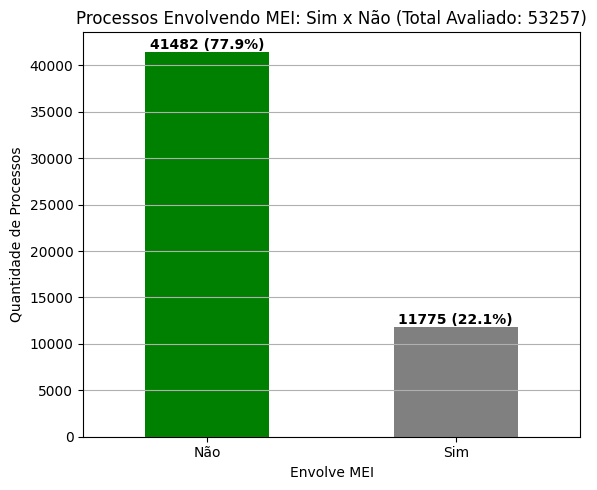

In [26]:


conn = get_connection()

# Consulta os dados
query = """
SELECT envolve_mei
FROM processos
WHERE envolve_mei IS NOT NULL;
"""
df = pd.read_sql(query, conn)
conn.close()

# Normaliza os valores
df['envolve_mei'] = df['envolve_mei'].replace({'1': 'Sim', '0': 'Não'})

# Conta os valores
contagem = df['envolve_mei'].value_counts()
total = contagem.sum()
porcentagem = (contagem / total * 100).round(1)

# Cria o gráfico
plt.figure(figsize=(6, 5))
ax = contagem.plot(kind='bar', color=['green', 'gray'])

# Título com total de processos
plt.title(f'Processos Envolvendo MEI: Sim x Não (Total Avaliado: {total})')
plt.xlabel('Envolve MEI')
plt.ylabel('Quantidade de Processos')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()

# Adiciona rótulos com total e percentual
for i, (valor_total, valor_pct) in enumerate(zip(contagem.values, porcentagem.values)):
    ax.text(i, valor_total + 0.5, f'{valor_total} ({valor_pct}%)',
            ha='center', va='bottom', fontweight='bold')

# Exibe o gráfico
plt.show()


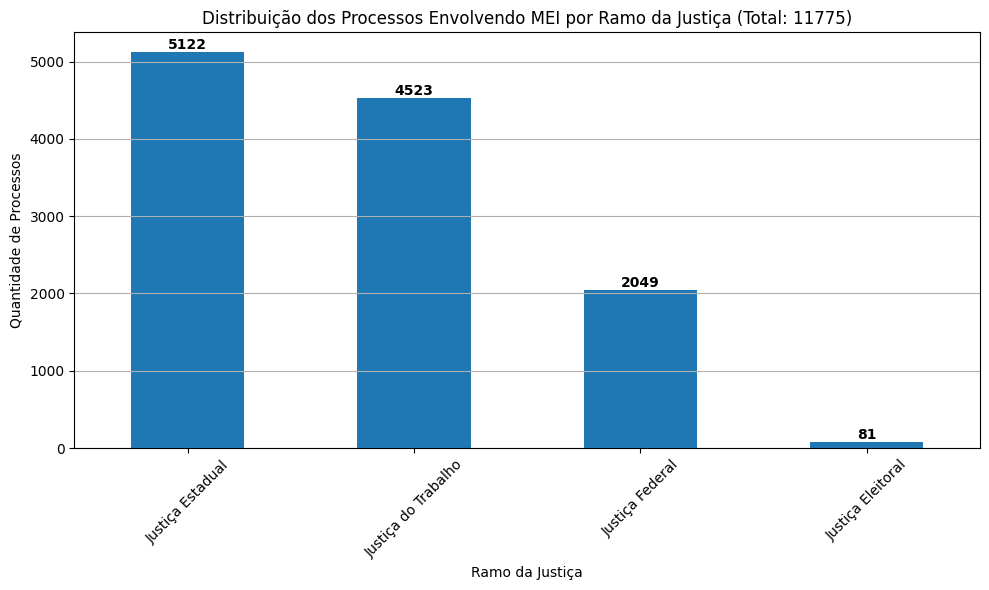

In [27]:
# Conexão com o banco PostgreSQL
conn =  get_connection()

# Consulta os dados
query = """
SELECT ramo_justica
FROM processos
WHERE envolve_mei = 'Sim' AND ramo_justica IS NOT NULL;
"""

# Lê os dados para um DataFrame
df = pd.read_sql(query, conn)

# Fecha a conexão
conn.close()

# Conta os valores por ramo da justiça
contagem = df['ramo_justica'].value_counts()
total = contagem.sum()

# Cria o gráfico
plt.figure(figsize=(10, 6))
ax = contagem.plot(kind='bar')

# Título com o total de processos
plt.title(f'Distribuição dos Processos Envolvendo MEI por Ramo da Justiça (Total: {total})')
plt.xlabel('Ramo da Justiça')
plt.ylabel('Quantidade de Processos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Adiciona rótulos em cima de cada barra
for i, v in enumerate(contagem.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Exibe o gráfico
plt.show()

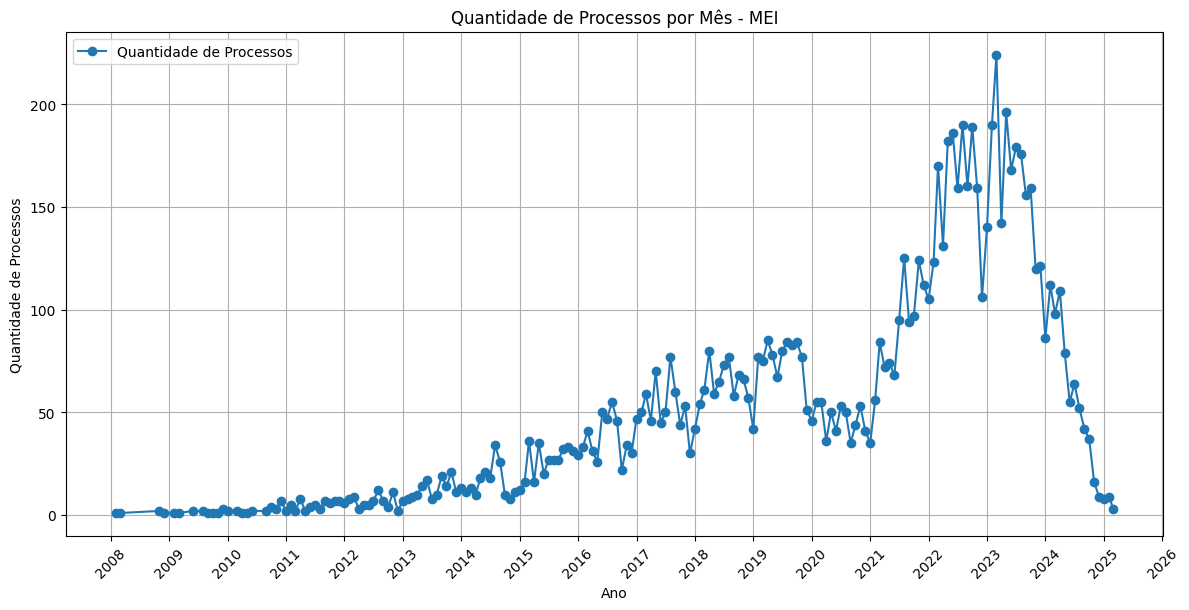

In [28]:
import matplotlib.dates as mdates
conn =  get_connection()

# Consulta SQL
query = """
SELECT 
    TO_CHAR(dataajuizamento, 'YYYY-MM') AS ano_mes,
    COUNT(*) AS qtd_processos
FROM processos AS proc
LEFT JOIN metadados_datajud AS meta 
    ON proc.numero_processo_tribunal = meta.numero_processo_tribunal
WHERE descricao_caso IS NOT NULL 
  AND questoes_em_discussao IS NOT NULL 
  AND envolve_mei = 'Sim'
  AND dataajuizamento >= DATE '2008-01-01'
GROUP BY TO_CHAR(dataajuizamento, 'YYYY-MM')
ORDER BY ano_mes;
"""

# Executar consulta e carregar em DataFrame
df = pd.read_sql_query(query, conn)
conn.close()

# Conversão da coluna para datetime
df['ano_mes'] = pd.to_datetime(df['ano_mes'])

# Ordenar
df = df.sort_values('ano_mes')

# Plotar gráfico
plt.figure(figsize=(12, 6))
plt.plot(df['ano_mes'], df['qtd_processos'], marker='o', label='Quantidade de Processos')

# Eixo X: mostrar todos os anos
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Quantidade de Processos por Mês - MEI')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Processos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()



# Geração dos embeddings - DESCRIÇÃO + QUESTÕES

In [29]:
import numpy as np
# Caminho local para o modelo BERTimbau (em formato PyTorch)
bert_model_path = "C:/Users/Loreane/Documents/bert"

# Define dispositivo (usa GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carrega tokenizer e modelo
tokenizer = AutoTokenizer.from_pretrained(bert_model_path)
model = AutoModel.from_pretrained(bert_model_path).to(device)
model.eval()

# Função para gerar embedding médio da última camada oculta
def gerar_vetor(texto):
    with torch.no_grad():
        inputs = tokenizer(
            texto,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)

        outputs = model(**inputs)
        vetor = torch.mean(outputs.last_hidden_state, dim=1)
        return vetor.squeeze().cpu().numpy()  # vetor como array numpy

# Conexão com PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="PROCESSOS",
    user="postgres",
    password="admin"
)
cur = conn.cursor()

# Seleciona registros para vetorizar
cur.execute("""
    SELECT id, descricao_caso, questoes_em_discussao 
    FROM processos 
    WHERE descricao_caso IS NOT NULL 
      AND questoes_em_discussao IS NOT NULL 
      AND vetor_descricao_questoes IS NULL 
      AND envolve_mei = 'Sim'
""")

registros = cur.fetchall()

total = len(registros)

# Processa e atualiza os vetores
for i, (id_proc, desc, quest) in enumerate(registros, start=1):
    clear_output(wait=True)
    texto = f"{desc.strip()} {quest.strip()}"
    vetor = gerar_vetor(texto)
    vetor_str = '[' + ','.join(map(str, vetor)) + ']'

    cur.execute("""
        UPDATE processos 
        SET vetor_descricao_questoes = %s 
        WHERE id = %s
    """, (vetor_str, id_proc))
    
    print(f"✅ Processo {i} de {total} atualizado (ID: {id_proc})")
    conn.commit()


cur.close()
conn.close()


✅ Processo 399 de 399 atualizado (ID: 36891)


In [ ]:
# Geração dos embeddings - TESE + QUESTÕES